<a href="https://colab.research.google.com/github/gopalapare/ddpg/blob/main/ddpg_pendulum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
problem = "Pendulum-v1"
env = gym.make(problem)

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]


print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  3
Size of Action Space ->  1
Max Value of Action ->  2.0
Min Value of Action ->  -2.0


/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [ ]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [ ]:
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

In [ ]:
def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return [np.squeeze(legal_action)]

In [ ]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 100
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

buffer = Buffer(50000, 64)

Episode * 0 * Avg Reward is ==> -1512.7446973987633
Episode * 1 * Avg Reward is ==> -1301.9140330365312
Episode * 2 * Avg Reward is ==> -1375.5730713044795
Episode * 3 * Avg Reward is ==> -1390.691179577014
Episode * 4 * Avg Reward is ==> -1346.1883599846947
Episode * 5 * Avg Reward is ==> -1396.8632497989665
Episode * 6 * Avg Reward is ==> -1416.658438658727
Episode * 7 * Avg Reward is ==> -1416.0688454942983
Episode * 8 * Avg Reward is ==> -1392.1775994717811
Episode * 9 * Avg Reward is ==> -1350.3580045782371
Episode * 10 * Avg Reward is ==> -1314.8514996444128
Episode * 11 * Avg Reward is ==> -1280.8991568625713
Episode * 12 * Avg Reward is ==> -1256.4552444086144
Episode * 13 * Avg Reward is ==> -1185.1863139734762
Episode * 14 * Avg Reward is ==> -1132.1626593826381
Episode * 15 * Avg Reward is ==> -1077.2348701227509
Episode * 16 * Avg Reward is ==> -1021.6375064452809
Episode * 17 * Avg Reward is ==> -986.8645689594297
Episode * 18 * Avg Reward is ==> -941.5383708306755
Episode

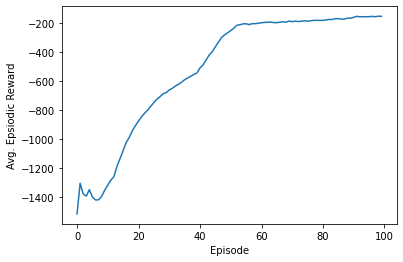

In [ ]:
# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

# Takes about 4 min to train
for ep in range(total_episodes):

    prev_state = env.reset()
    episodic_reward = 0

    while True:
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()

        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)
        # Recieve state and reward from environment.
        state, reward, done, info = env.step(action)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)

        # End this episode when `done` is True
        if done:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)

# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

In [ ]:
# Save the weights
actor_model.save_weights("pendulum_actor.h5")
critic_model.save_weights("pendulum_critic.h5")

target_actor.save_weights("pendulum_target_actor.h5")
target_critic.save_weights("pendulum_target_critic.h5")

In [ ]:
import numpy as np
a=np.array([2,3,4,6])
b=a.shape[0]
m=np.zeros_like([3,5,7])
m

array([0, 0, 0])

In [ ]:

import mpctools as mpc
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/home/rui/Documents/RL_vs_MPC/Models')
sys.path.insert(0, '/home/rui/Documents/RL_vs_MPC/RL_Codes')
sys.path.insert(0, '/Users/ruinian/Documents/Research/Modules')
sys.path.insert(0, '/home/rui/Documents/Research/Modules')

from RL_Module_Updated import *

"""
Define reward function for RL.  User defines the reward function structure.  The below is an example.
"""


# Model for MechaTronix
def model(action):
    """
    Action: Total pump frequency (not delta pump frequency)
    """
    return 0.01158682 * np.square(action) + 0.02409036 * action - 2.073161


# Reward function
def reward_calc(state, setpoint):
    return max(-np.square(state - setpoint), -150)


def simulation():

    # Reinforcement Learning Initiation
    rl = ReinforceLearning(discount_factor=0.95, states_start=300, states_stop=340, states_interval=0.5,
                           actions_start=-15, actions_stop=15, actions_interval=2.5, learning_rate=0.5,
                           epsilon=0.2, doe=1.2, eval_period=5)

    """
    Example of user defined states and actions.  Users do not need to do this.  This is only if users want to define 
    their own states and actions.  RL will automatically populate states and actions if user does not input their own.
    """

    states = []

    rl.x1 = np.linspace(-20, 20, 21)
    rl.x2 = np.linspace(1, 3, 3)

    for i in rl.x1:
        for j in rl.x2:
            states.append([i, j])

    rl.user_states(list(states))

    actions = np.linspace(-10, 10, 21)
    rl.user_actions(list(actions))

    """
    Load pre-trained Q, T and NT matrices
    """

    q = np.loadtxt("Q_Matrix.txt")
    t = np.loadtxt("T_Matrix.txt")
    nt = np.loadtxt("NT_Matrix.txt")

    rl.user_matrices(q, t, nt)

    """
    Simulation portion
    """

    episodes = 1
    num_sim = 100
    rlist = []

    for episode in range(episodes):

        # Environment parameters
        env_states = np.zeros((num_sim + 1, 2))
        env_states[0, :] = [10.5, 2]

        error = np.zeros(num_sim + 1)

        env_actions = np.zeros(num_sim + 1)
        env_actions[0] = 32

        # Reset the model after each episode
        tot_reward = 0

        # State and action indices
        state = 0
        action = 0

        if episode % 22 == 0:
            cur_setpoint = 25     # np.random.uniform(0, 60)
        else:
            cur_setpoint = 25     # np.random.uniform(0, 60)

        for t in range(1, num_sim + 1):

            """
            Set-point
            """

            error[t] = env_states[t - 1, 0] - cur_setpoint

            """
            Disturbance
            """

            # if t == 10:
            #     model.disturbance()

            """
            RL Evaluate
            """

            if t % rl.eval_period == 0:
                # State: index of state; actions: Physical action; action: index of action
                state, env_actions[t], action = rl.action_selection(np.array([error[t], env_states[t - 1, 1]]),
                                                                    env_actions[t - 1],
                                                                    25, ep_greedy=False, time=t,
                                                                    min_eps_rate=0.9)

            else:
                env_actions[t] = env_actions[t - 1]

            # State evolution/trajectory
            env_states[t, 0] = model(env_actions[t])  # + np.random.uniform(-0.1, 0.1)

            if env_states[t, 0] < 10:
                env_states[t, 1] = 1
            elif 10 <= env_states[t, 0] < 20:
                env_states[t, 1] = 2
            else:
                env_states[t, 1] = 3

            """
            Feedback evaluation
            """

            if t == rl.eval_feedback:
                reward = reward_calc(env_states[t, 0], cur_setpoint)
                rl.matrix_update(action, reward, state, np.array([error[t], env_states[t, 1]]), 5)
                tot_reward = tot_reward + reward

        rlist.append(tot_reward)

        rl.autosave(episode, 5)

        if episode % 100 == 0:
            print('The current error is: {:2f}'.format(np.sqrt(np.sum(np.square(env_states[:, 0] - cur_setpoint)))))

    # Plotting
    fonts = {"family": "serif",
             "weight": "normal",
             "size": "12"}

    plt.rc('font', **fonts)
    plt.rc('text', usetex=True)

    plt.plot(env_states[:, 0])
    plt.xlabel('Pump RPM, (Hertz)')
    plt.ylabel('Pressure, P')

    plt.axhline(y=cur_setpoint, color='red')

    plt.text(x=750, y=34.5, s='Set point')
    plt.text(x=750, y=35.9, s='Pressure Trajectory')

    # plt.ylim([33, 43])

    plt.show()

    #return model, rl, rlist, env_states, env_actions


# if __name__ == "__main__":
simulation()



ValueError: ignored

In [ ]:
tf.keras.layers.InputLayer(
    input_shape=None,
    batch_size=None,
    dtype=None,
    input_tensor=None,
    sparse=None,
    name=None,
    ragged=None,
    type_spec=None,
)
# With explicit InputLayer.
model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(4,)),
  tf.keras.layers.Dense(8)])
model.compile(tf.keras.optimizers.RMSprop(0.001), loss='mse')
model.fit(np.zeros((10, 4)),
          np.ones((10, 8)))

# Without InputLayer and let the first layer to have the input_shape.
# Keras will add a input for the model behind the scene.
model = tf.keras.Sequential([
  tf.keras.layers.Dense(8, input_shape=(4,))])
model.compile(tf.keras.optimizers.RMSprop(0.001), loss='mse')
model.fit(np.zeros((10, 4)),
          np.ones((10, 8)))

1/1 [==============================] - 0s 321ms/step - loss: 1.0000
